In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:02<00:00, 162MB/s]
100% 5.20G/5.20G [01:02<00:00, 89.5MB/s]


In [ ]:
!mkdir -p General  # Створення папки General
!unzip /content/skin-cancer-mnist-ham10000.zip -d General

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: General/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: General/ham10000_images_part_2/ISIC_0

In [ ]:
!pip install imutils
!pip install efficientnet

import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
skinDf=pd.read_csv('/content/General/HAM10000_metadata.csv')
size=32
skinDf


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(skinDf['dx'])
skinDf['label']=labelEncoder.transform(skinDf['dx'])



In [ ]:
import plotly.express as px
fig = px.bar(skinDf['dx'].value_counts(), x=skinDf['dx'].value_counts().index, y=skinDf['dx'].value_counts().values,
             labels={'x': 'Class', 'y': 'Count'}, title='Distribution of Classes')
fig.show()

# Age distribution
fig = px.histogram(skinDf, x='age', title='Age Distribution')
fig.show()

# Sex distribution
fig = px.bar(skinDf['sex'].value_counts(), x=skinDf['sex'].value_counts().index, y=skinDf['sex'].value_counts().values,
             labels={'x': 'Sex', 'y': 'Count'}, title='Sex Distribution')
fig.show()

# Localization distribution
fig = px.bar(skinDf['localization'].value_counts(), x=skinDf['localization'].value_counts().index, y=skinDf['localization'].value_counts().values,
             labels={'x': 'Localization', 'y': 'Count'}, title='Localization Distribution')
fig.show()

In [ ]:
from sklearn.utils import resample
dfs_by_label_resampled = {}
n_samples = 800

for label in range(7):
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)

    # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['label'].value_counts()




label
5    800
2    800
3    800
4    800
1    800
0    800
6    800
Name: count, dtype: int64

In [ ]:

from glob import glob
from PIL import Image

imgPath={os.path.splitext(os.path.basename(x))[0]: x
                            for x in glob(os.path.join('/content/General/','*','*.jpg'))}

size = (64, 64)


balanced_df['image'] = balanced_df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(size)))


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
sampled_images = balanced_df['image'].sample(6, random_state=42)
size = (64, 64)
sampled_images = [Image.fromarray(img).resize(size) for img in sampled_images]

sampled_images = [np.array(img) for img in sampled_images]

fig = make_subplots(rows=2, cols=3, subplot_titles=("Image 1", "Image 2", "Image 3", "Image 4", "Image 5", "Image 6"))

for i, img in enumerate(sampled_images, start=1):
    fig.add_trace(go.Image(z=img), row=(i-1) // 3 + 1, col=(i-1) % 3 + 1)

fig.update_layout(
    title="Sample Images",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
)

fig.show()

In [ ]:
from keras.utils import to_categorical
x=np.asarray(balanced_df['image'].to_list())
x=x/255
y=balanced_df['label']
y=to_categorical(y,num_classes=7)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42,shuffle=True)



In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',input_shape=(64,64,3)))
model.add(layers.MaxPooling2D())
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', ))
model.add(BatchNormalization())

model.add(Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train ,
                    y_train ,
                    epochs=50 ,
                    batch_size=8,
                    validation_data=(x_test , y_test) ,
                    )

Epoch 1/50
560/560 [==============================] - 140s 235ms/step - loss: 2.0662 - accuracy: 0.1982 - val_loss: 1.7661 - val_accuracy: 0.3089
Epoch 2/50
560/560 [==============================] - 122s 218ms/step - loss: 1.8086 - accuracy: 0.2737 - val_loss: 1.6500 - val_accuracy: 0.3295
Epoch 3/50
560/560 [==============================] - 132s 236ms/step - loss: 1.6892 - accuracy: 0.3132 - val_loss: 1.6029 - val_accuracy: 0.3562
Epoch 4/50
560/560 [==============================] - 122s 217ms/step - loss: 1.6909 - accuracy: 0.3167 - val_loss: 1.6010 - val_accuracy: 0.3509
Epoch 5/50
560/560 [==============================] - 116s 207ms/step - loss: 1.5545 - accuracy: 0.3958 - val_loss: 1.4456 - val_accuracy: 0.4437
Epoch 6/50
560/560 [==============================] - 121s 217ms/step - loss: 1.4605 - accuracy: 0.4254 - val_loss: 1.2961 - val_accuracy: 0.5098
Epoch 7/50
560/560 [==============================] - 118s 211ms/step - loss: 1.3828 - accuracy: 0.4641 - val_loss: 1.3532 -

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

35/35 [==============================] - 5s 146ms/step - loss: 0.4186 - accuracy: 0.8768
Test Accuracy: 0.8767856955528259
Test Loss: 0.41860994696617126


In [ ]:
import matplotlib.pyplot as plt

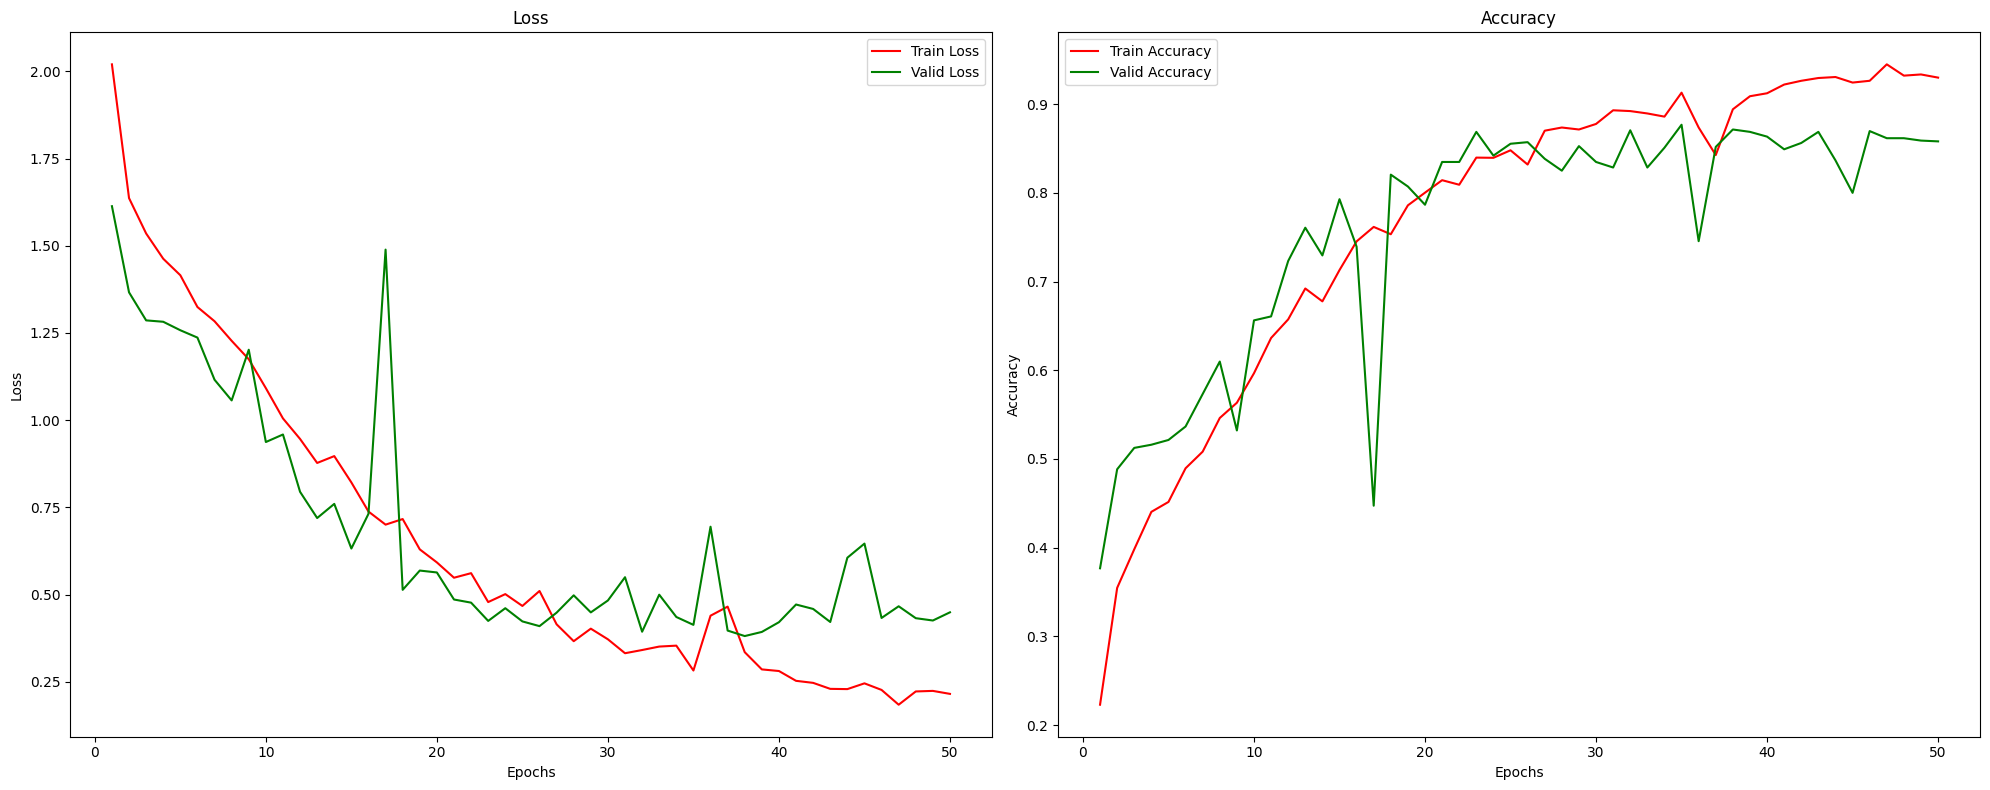

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 70ms/step
Class probabilities:
Class Melanocytic_nevi: 0.22
Class melanoma: 0.00
Class Benign_keratosis-like_lesions: 0.01
Class Basal_cell_carcinoma: 0.00
Class Actinic_keratoses: 0.74
Class Vascular_lesions: 0.02
Class Dermatofibroma: 0.00
Predicted class: Actinic_keratoses


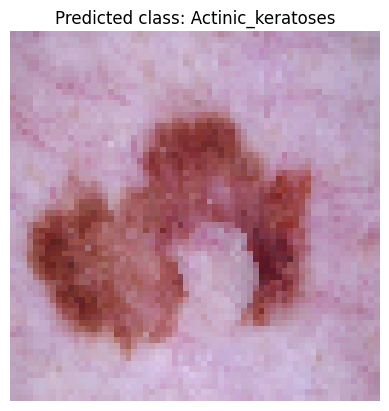

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path):
    # Завантажити зображення
    img = image.load_img(img_path, target_size=(64, 64))
    # Перетворити зображення в масив
    img_array = image.img_to_array(img)
    # Нормалізувати зображення
    img_array = img_array / 255.0
    # Додати розмірність для батча
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Словник для відповідності індексів класів їх назвам
lesion_type_dict = {
    'nv': 'Melanocytic_nevi',
    'mel': 'melanoma',
    'bkl': 'Benign_keratosis-like_lesions',
    'bcc': 'Basal_cell_carcinoma',
    'akiec': 'Actinic_keratoses',
    'vasc': 'Vascular_lesions',
    'df': 'Dermatofibroma'
}

class_labels = {i: lesion_type_dict[key] for i, key in enumerate(lesion_type_dict.keys())}

def classify_image_detailed(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    probabilities = prediction[0]
    predicted_class = np.argmax(probabilities)

    print("Class probabilities:")
    for idx, prob in enumerate(probabilities):
        print(f"Class {class_labels[idx]}: {prob:.2f}")

    print(f"Predicted class: {class_labels[predicted_class]}")

    original_img = image.load_img(img_path, target_size=(64, 64))
    plt.imshow(original_img)
    plt.title(f"Predicted class: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

    return predicted_class

img_path = '/content/General/HAM10000_images_part_2/ISIC_0034263.jpg'
predicted_class = classify_image_detailed(img_path, model)